In [1]:
import cv2
import glob
import time
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

## 1. Possible features

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## 2. Extract a combination of features from a list of images

In [3]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)/255

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 3. Read in images and train a support vector machine

In [9]:
cars=glob.glob('./vehicles_smallset/*/*.png', recursive=True)
notcars=glob.glob('./non-vehicles_smallset/*/*.png', recursive=True)
print(len(cars),len(notcars))

1196 1125


In [10]:
# Helper function to plot images
def plots(rows, cols, imgs, titles, axis='on', figsize=(14, 10),file=''):
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(titles[i])
        plt.axis(axis)
        plt.imshow(img)
    if file!=None:
        plt.savefig(file)
    plt.show()


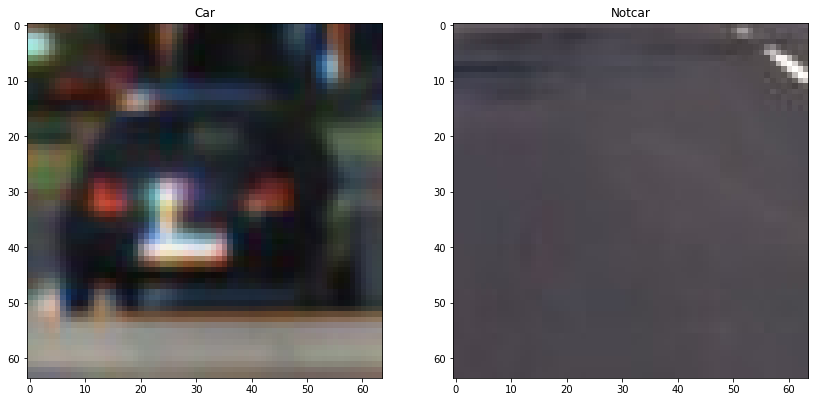

In [11]:
car_notcar=[mpimg.imread(cars[10]),mpimg.imread(notcars[10])]
titles=['Car','Notcar']
plots(1,2,car_notcar,titles,'on',(14,7),'output_images/car_notcar.jpg')
#plt.imshow(car_notcar[0])

In [12]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

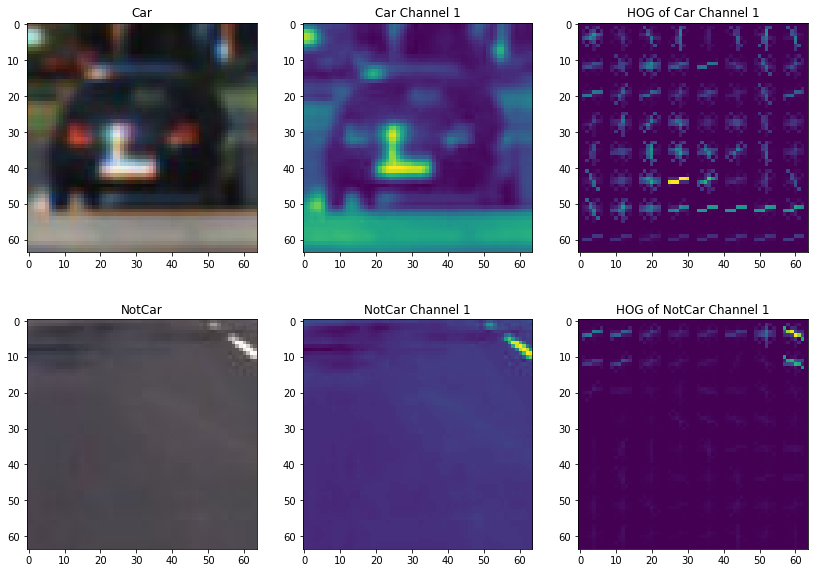

In [13]:
car=cv2.cvtColor(car_notcar[0],cv2.COLOR_RGB2YCrCb)
notcar=cv2.cvtColor(car_notcar[1],cv2.COLOR_RGB2YCrCb)
car_f,car_hog_image=get_hog_features(car[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
notcar_f,notcar_hog_image=get_hog_features(notcar[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
feature_images=[car_notcar[0],car[:,:,0],car_hog_image,car_notcar[1],notcar[:,:,0],notcar_hog_image]
titles=['Car','Car Channel 1','HOG of Car Channel 1','NotCar','NotCar Channel 1','HOG of NotCar Channel 1']
plots(2,3,feature_images,titles,'on',(14,10),'output_images/features.jpg')

In [14]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
1.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9914


## 4. Extract features from a single image 

In [15]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):  
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## 5. Find cars by sliding windows

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                draw_img[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left: xbox_left+win_draw] += 1
    draw_img[:,:draw_img.shape[1]//2]=0
    return draw_img

## 6. Test on example images

In [109]:
def labelVeh(img,labels):
    for car_number in range (1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox)-15, np.min(nonzeroy)-15), (np.max(nonzerox)+15, np.max(nonzeroy)+15))
        cv2.rectangle(img, bbox[0], bbox[1], (255, 255, 0), 5)
    return img

In [110]:
example_image_filenames = glob.glob('test_images/*.jpg')
example_images=[]
for file in example_image_filenames:
    image=mpimg.imread(file)
    #image = image.astype(np.float32)/255
    example_images.append(image)

29
30
2
9
29
29
64.2 minutes estimated time for video


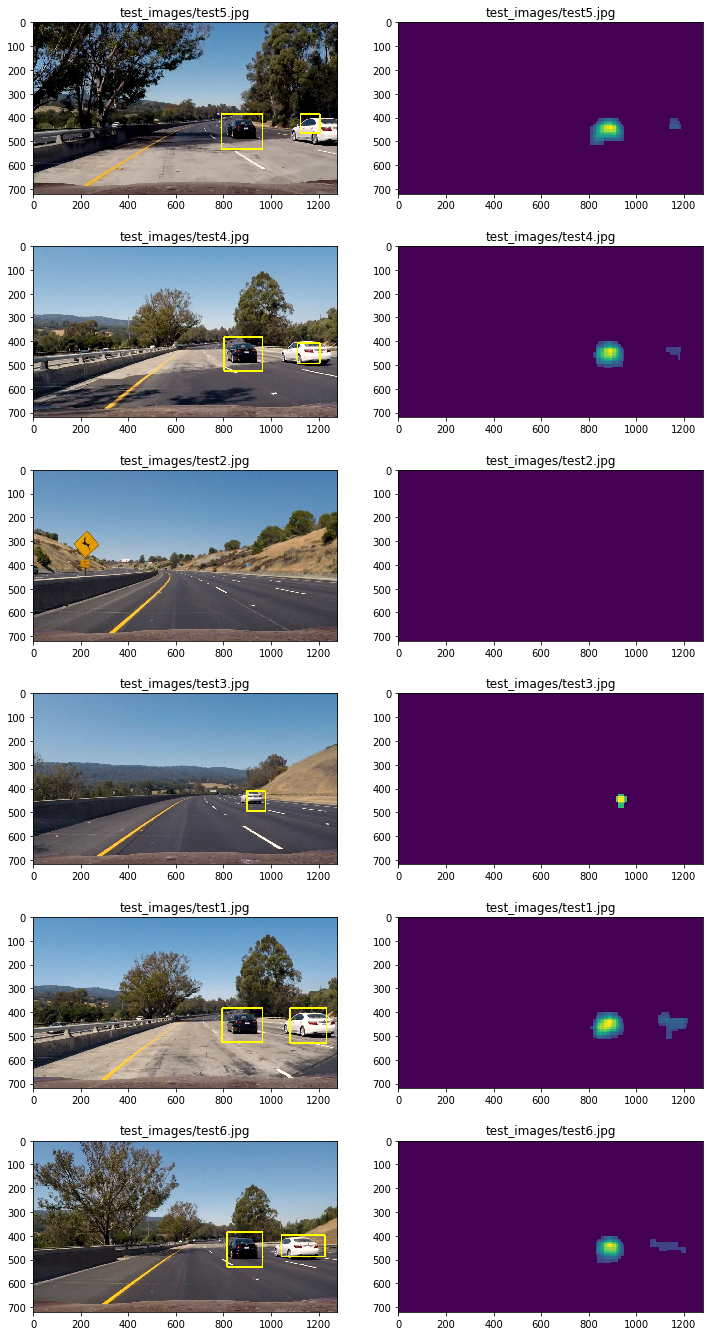

In [111]:
out_images = []
out_maps = []
out_titles = []
scale1 = 1.8
scale2=1.0
scale3=0.75
dilateKernel = np.uint8(np.ones((50,50)))#higher,wider
erodeKernel = np.uint8(np.ones((50,50)))#shorter,thiner
t=time.time()

for i, img in enumerate(example_images):
    heat_map1=find_cars(img, y_start_stop[0], y_start_stop[1], scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat_map2=find_cars(img, y_start_stop[0], y_start_stop[1], scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat_map3=find_cars(img, y_start_stop[0], y_start_stop[1], scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat_map =heat_map1+heat_map2+heat_map3
    

    heat_map = cv2.dilate(heat_map,dilateKernel)

    heat_map = cv2.erode(heat_map,erodeKernel)

    
    print(np.max(heat_map))
    heat_map[heat_map<6]=0
    
    #heat_map = applyThrehold(heat_map, 0.5)
    labels = label(heat_map)
    draw_img = labelVeh(img, labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(example_image_filenames[i].split('\\')[-1])
    out_titles.append(example_image_filenames[i].split('\\')[-1])
print(round((time.time()-t)/6*21,1), 'minutes estimated time for video')
plots(6, 2, out_images, out_titles, 'on',(12, 24), 'output_images/tests.jpg')
#plots(1,2,car_notcar,titles,'on',(14,10),'output_images/car_notcar.jpg')


## 7. Video Pipeline

In [117]:
scale1 = 1.8
scale2=1
scale3=0.75
threshold=18
frame=1
last_info=np.zeros_like(heat_map)
last_info=[last_info,last_info,last_info]

In [118]:
def process_image(image):
    heat_map1=find_cars(image, y_start_stop[0], y_start_stop[1], scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat_map2=find_cars(image, y_start_stop[0], y_start_stop[1], scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat_map3=find_cars(image, y_start_stop[0], y_start_stop[1], scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    heat_map = heat_map1+heat_map2+heat_map3   
    heat_map = cv2.dilate(heat_map,dilateKernel)
    
    global frame
    if frame<4:
        last_info[frame-1]=heat_map
    else:
        old_heat_map=heat_map
        heat_map=old_heat_map+last_info[0]+last_info[1]+last_info[2]
        
        heat_map[heat_map<threshold]=0
        
        heat_map = cv2.erode(heat_map,erodeKernel)
        
        last_info[0]=last_info[1]
        last_info[1]=last_info[2]
        last_info[2]=old_heat_map
    labels = label(heat_map)
    draw_img = labelVeh(image, labels)
    #print(frame)
    frame=frame+1
    return draw_img

In [119]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

origin_output = './final_project_video.mp4'
clip = VideoFileClip('./project_video.mp4')
final_clip = clip.fl_image(process_image)
%time final_clip.write_videofile(origin_output, audio=False)

[MoviePy] >>>> Building video ./final_project_video.mp4
[MoviePy] Writing video ./final_project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:02<59:56,  2.85s/it]

  0%|          | 2/1261 [00:06<1:03:00,  3.00s/it]

  0%|          | 3/1261 [00:09<1:01:57,  2.95s/it]

  0%|          | 4/1261 [00:12<1:02:17,  2.97s/it]

  0%|          | 5/1261 [00:14<1:01:21,  2.93s/it]

  0%|          | 6/1261 [00:17<1:01:29,  2.94s/it]

  1%|          | 7/1261 [00:20<1:01:09,  2.93s/it]

  1%|          | 8/1261 [00:23<1:00:43,  2.91s/it]

  1%|          | 9/1261 [00:26<1:01:01,  2.92s/it]

  1%|          | 10/1261 [00:29<1:02:56,  3.02s/it]

  1%|          | 11/1261 [00:33<1:05:46,  3.16s/it]

  1%|          | 12/1261 [00:36<1:04:13,  3.09s/it]

  1%|          | 13/1261 [00:39<1:03:03,  3.03s/it]

  1%|          | 14/1261 [00:42<1:02:09,  2.99s/it]

  1%|          | 15/1261 [00:44<1:01:14,  2.95s/it]

  1%|▏         | 16/1261 [00:47<1:00:58,  2.94s/it]

  1%|▏         | 17/1261 [00:50<1:00:16,  2.91s/it]

  1%|▏         | 18/1261 [00:53<1:00:35,  2.92s/it]

  2%|▏       

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./final_project_video.mp4 

CPU times: user 1h 7min 3s, sys: 13 s, total: 1h 7min 16s
Wall time: 1h 6min 48s
